# 12wk-2: 순환신경망 (3) – `RNN`, `LSTM`

최규빈  
2024-05-22

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/12wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xq0bBQn8ZP607mS0ZKI8Sg&si=-cQULuc2x7noftgE>

# 2. Import

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
soft = torch.nn.Softmax(dim=1)

# 3. `AbAcAd` – `RNN` + GPU

## A. Data

`-` 데이터 정리

In [ ]:
txt = list('AbAcAd'*50)
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [ ]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

,x,y
0,A,b
1,b,A
2,A,c
3,c,A
4,A,d


## B. 구현1 – RNNCell (지난시간)

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

`-` 데이터정리

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

`-` Net설계 및 가중치 설정 (구현1과 동일하도록 가중치 초기화)

In [ ]:
torch.manual_seed(4) # 이거를 고정해야함 초기값에 따라 학습이 잘 안될수도... 왜 ? : Embedding space가 좁아서..
rnncell = torch.nn.RNNCell(4,2) #간장 만드는 거
cook = torch.nn.Linear(2,4) #간계밥 만드는 거

`-` 손실함수 및 옵티마이저 설정

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()),lr=0.1) #간장이 맛있는게 관건.. 즉 rnncell이 중요하다..

In [ ]:
L = len(X) #적합하는 알고리즘 다시 공부하기..
for epoc in range(200):
    ## 1~2
    loss = 0
    ht = torch.zeros(2) # 첫 간장은 맹물
    for t in range(L):
        Xt,yt = X[t],y[t]
        ht = rnncell(Xt,ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt)
    loss = loss/L
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
h = torch.zeros(L,2) #L년치 간장
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))
yhat #결과를 뽑기가 좀 힘들다...

tensor([[2.1032e-03, 7.4842e-01, 2.4849e-01, 9.8889e-04],
        [9.9601e-01, 6.1446e-05, 3.9266e-03, 2.8410e-09],
        [5.0120e-05, 2.2370e-02, 9.7758e-01, 2.4301e-07],
        ...,
        [5.0229e-05, 2.2415e-02, 9.7753e-01, 2.4399e-07],
        [9.9858e-01, 9.3153e-05, 1.3902e-08, 1.3301e-03],
        [2.2351e-05, 1.9198e-02, 1.1779e-07, 9.8078e-01]],
       grad_fn=<SoftmaxBackward0>)

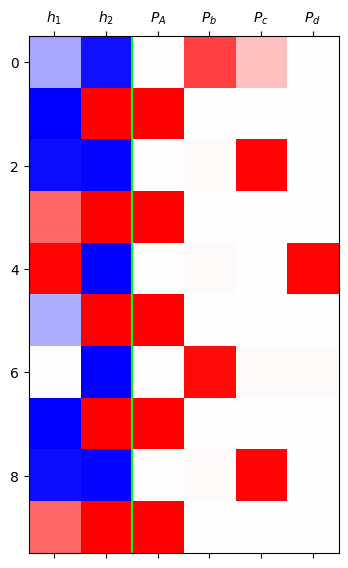

In [ ]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']); #뒤로 갈 수록 잘 맞추는 이유... 간장이 맛있어지기 때문...(임베딩을 잘 하기 때문.)

## C. 구현2 – RNN

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNN.html>

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [ ]:
torch.manual_seed(4)
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

In [ ]:
rnn = torch.nn.RNN(4,2) #원핫 인코딩 받아서 두개의 임베딩 스페이스로 받곘다.
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [ ]:
Water = torch.zeros(1,2) # 첫 간장은 맹물 디멘션이 포인트.? 원래 디멘션 무시해도 됐었는데...
for epoc in range(200):
    ## 1
    h,hL = rnn(X,Water)
    netout = cook(h)
    ## 2
    loss = loss_fn(netout, y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
h,_ = rnn(X,Water) #299개의 X를 그냥 한번에 집어넣고 뒤에 water를 같이 넣어준다... 그리고 언패킹해서 앞부분만 받는다. Water의 데이터 형태는 [[0,0]] 으로..
#사이즈가 2인 튜플이 나오는데 두번째 원소는 배치의 마지막 적합 결과가 나온다. 그게 다른 학습을 할 때 "물" 역할을 할 수 있다... (숙성된걸 쓰면 물보다는 좋겠지..)
yhat = soft(cook(h))
yhat #1번째 적합한 것과 Exact하게 same한 결과.

tensor([[2.1031e-03, 7.4839e-01, 2.4852e-01, 9.8869e-04],
        [9.9601e-01, 6.1449e-05, 3.9266e-03, 2.8409e-09],
        [5.0118e-05, 2.2371e-02, 9.7758e-01, 2.4303e-07],
        ...,
        [5.0227e-05, 2.2416e-02, 9.7753e-01, 2.4401e-07],
        [9.9858e-01, 9.3140e-05, 1.3895e-08, 1.3303e-03],
        [2.2354e-05, 1.9198e-02, 1.1780e-07, 9.8078e-01]],
       grad_fn=<SoftmaxBackward0>)

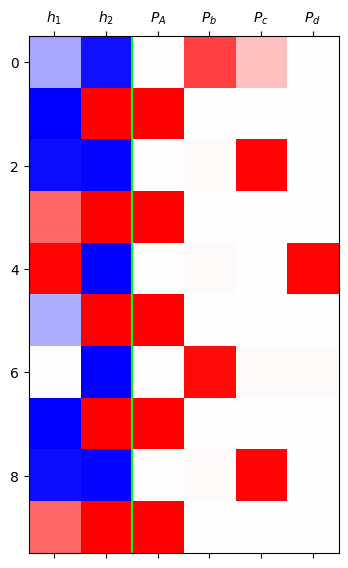

In [ ]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

## D. 구현3 – RNN + GPU

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [ ]:
torch.manual_seed(4)
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

In [ ]:
rnn = torch.nn.RNN(4,2)
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [ ]:
X = X.to("cuda:0")
y = y.to("cuda:0")
rnn.to("cuda:0")  #학습해야할 network의 가중치를 쿠다로 올린다.
cook.to("cuda:0")
Water = torch.zeros(1,2).to("cuda:0")
for epoc in range(200):
    ## 1
    h,hL = rnn(X,Water)
    netout = cook(h)
    ## 2
    loss = loss_fn(netout,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
h,hL = rnn(X,Water)
netout = cook(h)
yhat = soft(netout)
yhat

tensor([[2.1034e-03, 7.4854e-01, 2.4837e-01, 9.8962e-04],
        [9.9601e-01, 6.1436e-05, 3.9265e-03, 2.8413e-09],
        [5.0126e-05, 2.2367e-02, 9.7758e-01, 2.4292e-07],
        ...,
        [5.0234e-05, 2.2411e-02, 9.7754e-01, 2.4390e-07],
        [9.9858e-01, 9.3202e-05, 1.3930e-08, 1.3295e-03],
        [2.2335e-05, 1.9198e-02, 1.1778e-07, 9.8078e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

-   살짝결과다름

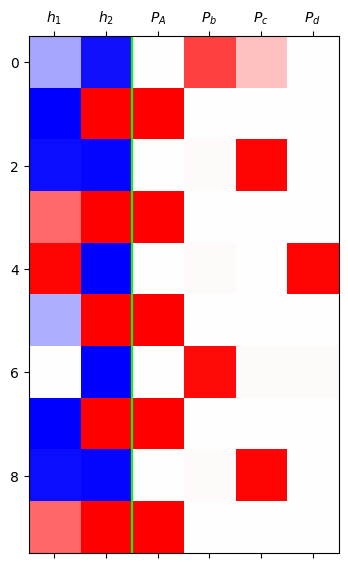

In [ ]:
mat = torch.concat([h,yhat],axis=1).data[:10].to("cpu")
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

## E. 구현4 – RNN + GPU + 맹물생략

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [ ]:
torch.manual_seed(4)
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

In [ ]:
rnn = torch.nn.RNN(4,2)
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [ ]:
X = X.to("cuda:0")
y = y.to("cuda:0")
rnn.to("cuda:0")
cook.to("cuda:0")
Water = torch.zeros(1,2).to("cuda:0")
for epoc in range(200):
    ## 1
    h,_ = rnn(X) #맹물을 지정하지 않아도... 알아서 넣어줍니다! 사실 Water의 디멘션을 엄밀히 따지지 않아도 괜찮았음..!
    netout = cook(h)
    ## 2
    loss = loss_fn(netout,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
h,_ = rnn(X)
netout = cook(h)
yhat = soft(netout)
yhat

tensor([[2.1034e-03, 7.4854e-01, 2.4837e-01, 9.8962e-04],
        [9.9601e-01, 6.1436e-05, 3.9265e-03, 2.8413e-09],
        [5.0126e-05, 2.2367e-02, 9.7758e-01, 2.4292e-07],
        ...,
        [5.0234e-05, 2.2411e-02, 9.7754e-01, 2.4390e-07],
        [9.9858e-01, 9.3202e-05, 1.3930e-08, 1.3295e-03],
        [2.2335e-05, 1.9198e-02, 1.1778e-07, 9.8078e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

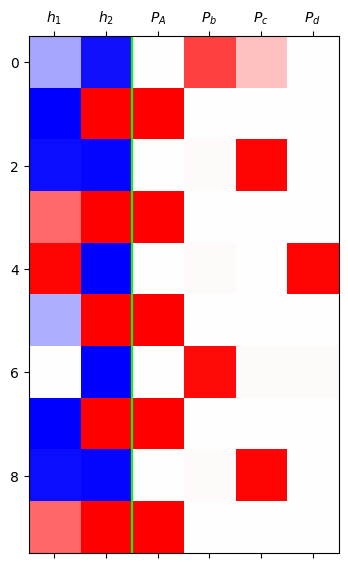

In [ ]:
mat = torch.concat([h,yhat],axis=1).data[:10].to("cpu")
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

## F. 은닉노드 비교실험

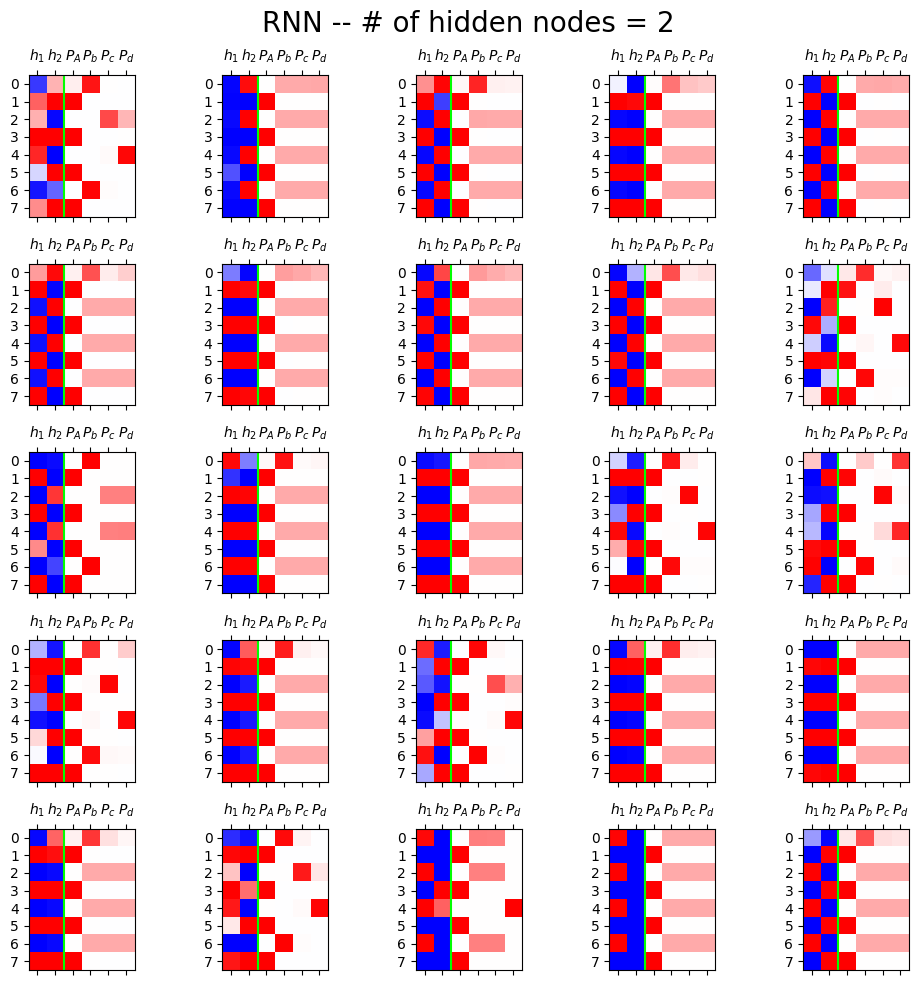

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3})) #h가 은닉노드..
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,2).to("cuda:0")
        cook = torch.nn.Linear(2,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu") #rnn의 첫번째 원소.. 언패킹 했던거 기억할 것..
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=1.5,color="lime")
        ax[i][j].set_xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 2",size=20)
fig.tight_layout()

#학습이 잘 된 부분하고 잘 안된 부분을 구별하는 특징이 있는데... 학습이 잘 된 경우는 임베딩 스페이스에 흰색이 있다..
#쨍할 수록 구분이 잘 되는건 맞지만 ,, 그건 구분을 잘 해야하는 경우의 문제고,. 이렇게 임베딩 스페이스에 넘치게 학습을 시킨경우, 색상차이가 얼마 나지 않는것을 캐치하는 것이 중요하다.
#스몰 b,c,d는 별로 중요하지 않았다는 포인트를 기억할 것.

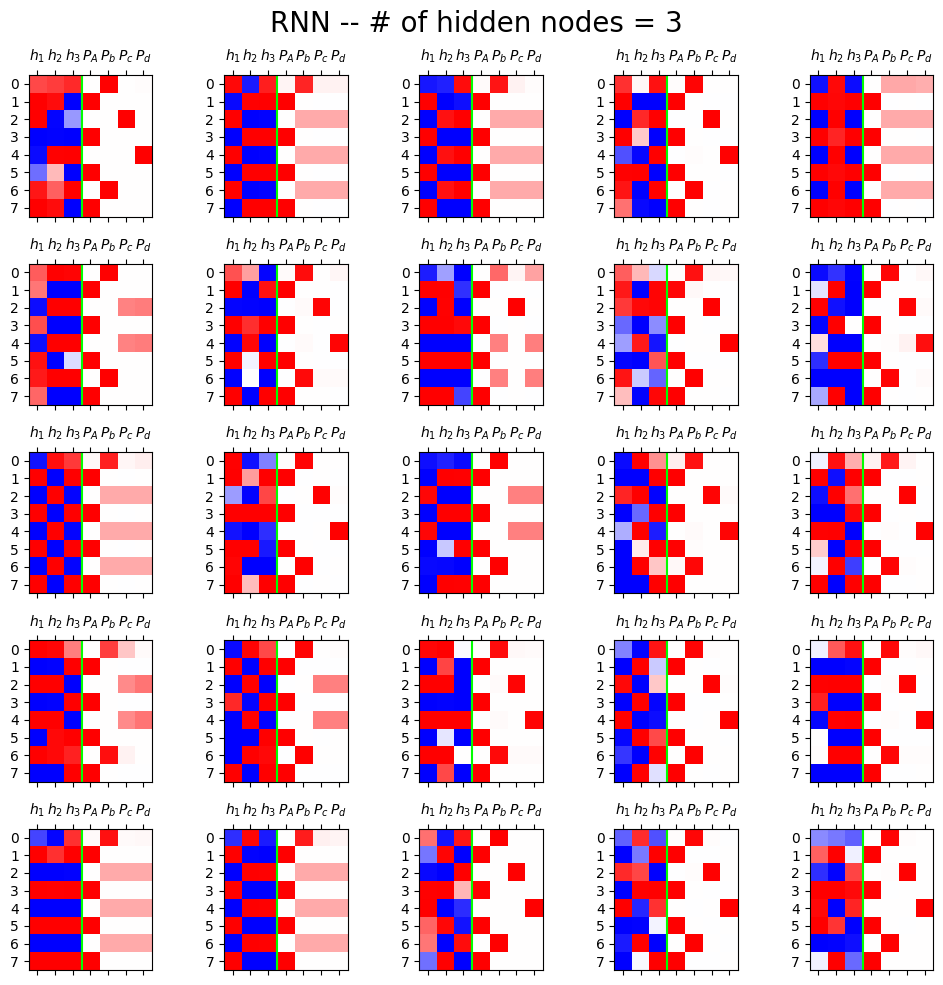

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,3).to("cuda:0")
        cook = torch.nn.Linear(3,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=2.5,color="lime")
        ax[i][j].set_xticks(range(7),[r'$h_1$',r'$h_2$',r'$h_3$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 3",size=20)
fig.tight_layout()

#임베딩 스페이스를 discrete하게 쓰려는 경우(딱딱 떨어지게) 학습이 실패하는 경우가 잦다.. 미세하게 잘 쓰지 못함
#임베딩 스페이스를 Continuous 하게 쓰려는 경우 학습이 잘 되는 경우가 많다. 미세하게 잘 씀
#굳이 이러고 싶지 않으면 임베딩 스페이스를 넓게 잡아주면 됨. 다음 예시가 그러함.

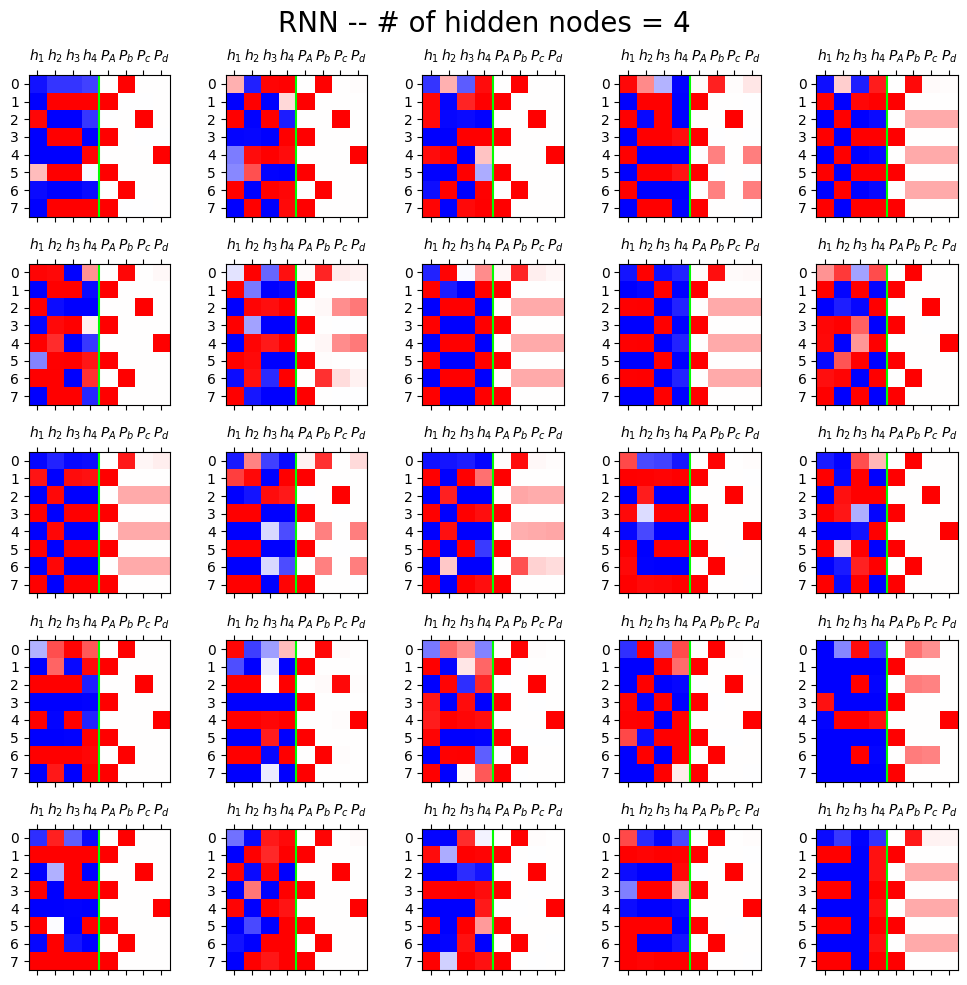

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,4).to("cuda:0")
        cook = torch.nn.Linear(4,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=3.5,color="lime")
        ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 4",size=20)
fig.tight_layout() #임베딩 스페이스를 넓게 쓰면.. (차원 많으면) 가중치를 -1 or 1 로 몰아주려는 경향이 생긴다... 임베딩 스페이스를 좁게 써야 잘 쓰는건데..
#어떻게 해야 좁게 잘 쓰지? LSTM

# 4. `abcabC`

## A. Data

`-` 데이터 정리

In [ ]:
txt = list('abcabC'*50)
txt[:10]

['a', 'b', 'c', 'a', 'b', 'C', 'a', 'b', 'c', 'a']

In [ ]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

,x,y
0,a,b
1,b,c
2,c,a
3,a,b
4,b,C


## B. RNN

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

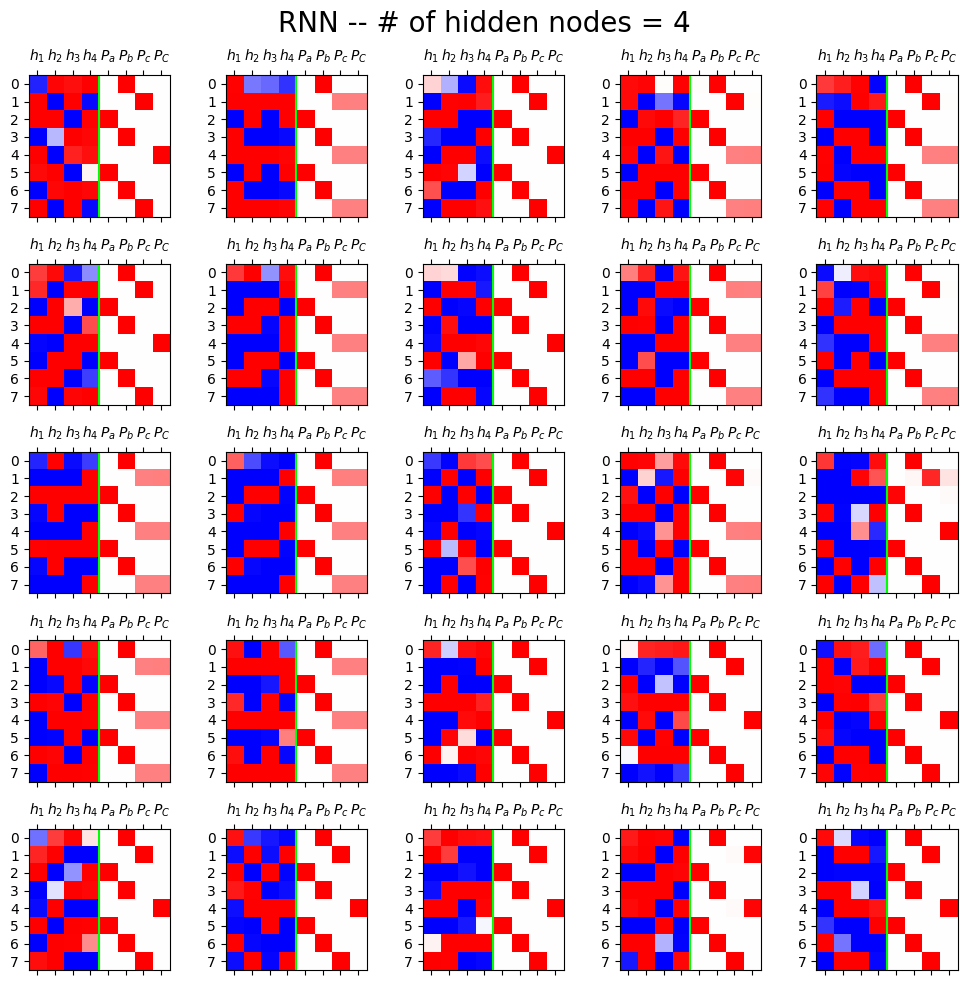

In [ ]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2,'C':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,4).to("cuda:0")
        cook = torch.nn.Linear(4,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(500):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=3.5,color="lime")
        ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_C$'])
fig.suptitle("RNN -- # of hidden nodes = 4",size=20)
fig.tight_layout() #C,c를 잘 구분하지 못하는 경우가 주된 실패 케이스..

## C. LSTM

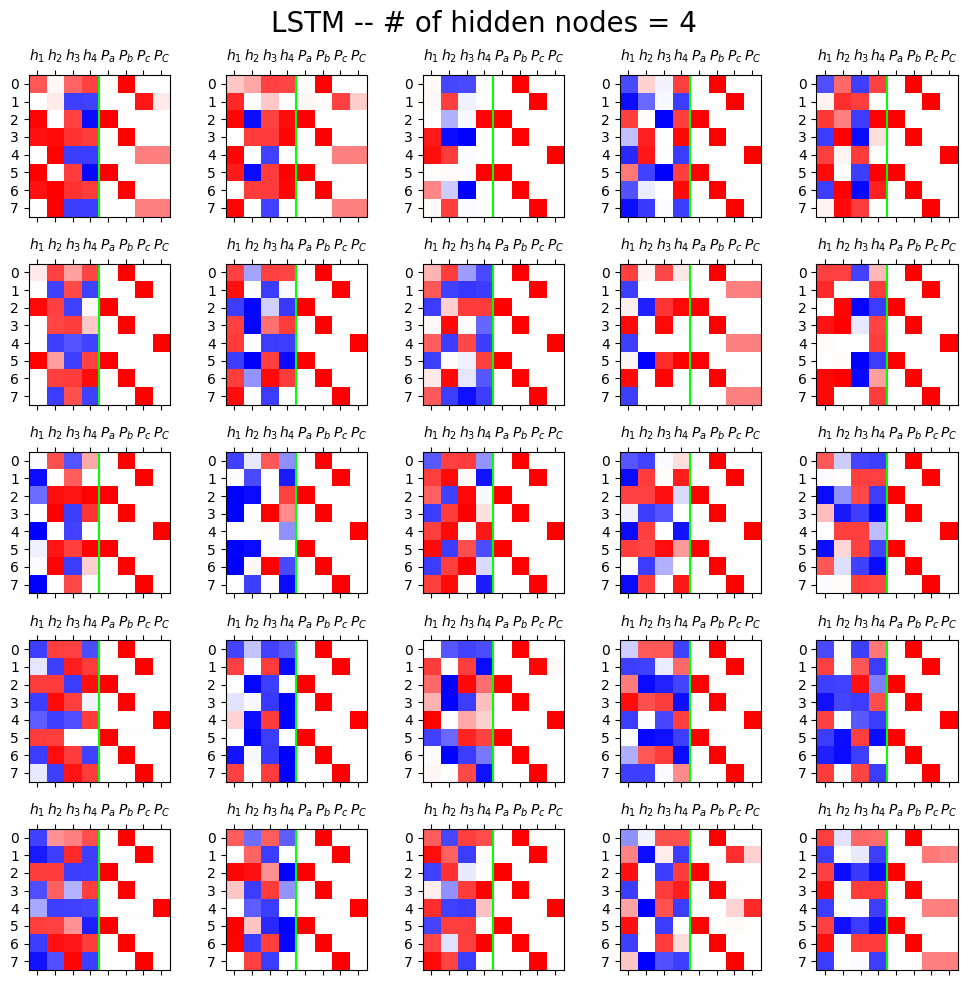

In [ ]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2,'C':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        lstm = torch.nn.LSTM(4,4).to("cuda:0") #RNN -> LSTM으로 바뀜
        cook = torch.nn.Linear(4,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(lstm.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(500):
            ## 1
            h,_ = lstm(X)
            netout = cook(h)
            ## 2
            loss = loss_fn(netout,y)
            ## 3
            loss.backward()
            ## 4
            optimizr.step()
            optimizr.zero_grad()
        h = lstm(X)[0].data.to("cpu")
        yhat = soft(cook(lstm(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr",vmin=-1,vmax=1)
        ax[i][j].axvline(x=3.5,color="lime")
        ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_C$'])
fig.suptitle("LSTM -- # of hidden nodes = 4",size=20)
fig.tight_layout() #임베딩 스페이스를 아주 자잘자잘하게 쓰는중... 좀더 많은 문자열에 대해서도 4개의 은닉노드 갖고 할 수 있을 거 같음.